In [46]:
import json
import re
import unicodedata
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns


In [47]:
with open("../data/professores.json", encoding="utf-8") as f:
    professores = json.load(f)


def tem_formacao(prof, nivel):
    for f in prof.get("formacao_academica", []):
        desc = f.get("tipo_formacao", "").lower()
        if nivel in desc:
            return "sim"

    return "não"


def calcular_anos_experiencia(prof):
    anos = []
    for f in prof.get("formacao_academica", []):
        tipo = f.get("tipo_formacao", "").lower()
        # Procura por graduação
        if "graduação" in tipo or "graduacao" in tipo:
            # Tenta pegar o ano de conclusão
            ano = f.get("ano_conclusao")
            if ano and str(ano).isdigit():
                anos.append(int(ano))
            else:
                # Alternativamente, tenta extrair do campo 'periodo'
                periodo = f.get("periodo", "")
                if " - " in periodo:
                    partes = periodo.split(" - ")
                    if len(partes) > 1 and partes[1].isdigit():
                        anos.append(int(partes[1]))
    if anos:
        return 2025 - min(anos)
    return None


In [48]:
dados = []

for prof in professores:
    nome = prof.get("identificacao", {}).get("nome", "")
    mestrado = tem_formacao(prof, "mestrado")
    doutorado = tem_formacao(prof, "doutorado")
    pos_doutorado = "sim" if prof.get("pos_doutorado") else "não"
    producoes = prof.get("producao_bibliografica", [])
    quantidade_producoes = len(producoes)
    coautores = prof.get("coautores_publicacoes", [])
    quantidade_coautores = len(coautores)
    anos_experiencia = calcular_anos_experiencia(prof)
    dados.append(
        {
            "nome": nome,
            "mestrado": mestrado,
            "doutorado": doutorado,
            "pos_doutorado": pos_doutorado,
            "anos_experiencia": anos_experiencia,
            "quantidade_producoes_bibliograficas": quantidade_producoes,
            "quantidade_coautores": quantidade_coautores,
            "producoes_bibliograficas": producoes,
            "coautores_publicacoes": coautores,
        }
    )

In [49]:
df = pd.DataFrame(dados)

In [50]:
df

nome mestrado doutorado pos_doutorado  \
0               Adriana Carla Damasceno      sim       sim           não   
1         Alan Kelon Oliveira de Moraes      sim       sim           não   
2          Alisson Vasconcelos de Brito      sim       sim           sim   
3   Alvaro Francisco de Castro Medeiros      sim       sim           não   
4                Ana Paula Pintado Wyse      sim       sim           sim   
..                                  ...      ...       ...           ...   
62                      Valdecir Becker      sim       sim           não   
63            Verônica Maria Lima Silva      sim       sim           não   
64   Vitor Meneghetti Ugulino de Araujo      sim       sim           não   
65    Yuri de Almeida Malheiros Barbosa      sim       sim           não   
66             Yuska Paola Costa Aguiar      sim       sim           sim   

    anos_experiencia  quantidade_producoes_bibliograficas  \
0                 22                                   43   
1                 20                                   39   
2                 24                                  189   
3                 40                                   53   
4                 28                                   54   
..               ...                                  ...   
62                23                                  287   
63                14                                   32   
64                16                                   15   
65                16                                   44   
66                21                                  141   

    quantidade_coautores                           producoes_bibliograficas  \
0                     50  [{'titulo': 'Supporting the choice of the best...   
1                     62  [{'titulo': 'A family of test selection criter...   
2                    311  [{'titulo': 'Fault diagnosis in split-system a...   
3                     45  [{'titulo': 'OBJECT-ORIENTED DEVELOPMENT SOFTW...   
4                     37  [{'titulo': 'Mathematical modeling of the perf...   
..                   ...                                                ...   
62                   143  [{'titulo': 'Avaliação de sistemas de Governo ...   
63                    58  [{'titulo': 'PREDICCIÓN Y DIAGNÓSTICO DEL ALZH...   
64                    43  [{'titulo': 'Bridging the Digital Divide: Unde...   
65                   108  [{'titulo': 'Assessment of volumetric dense ti...   
66                   199  [{'titulo': 'Desenvolvimento e Avaliação de Us...   

                                coautores_publicacoes  
0   [ALBUQUERQUE, R. S., ALBUQUERQUE, RENATO, ALVE...  
1   [ALBUQUERQUE, F. C. B., ALBUQUERQUE, J. O., AL...  
2   [ABREU, GIOVANNA, ALBUQUERQUE, D. W., ALEXANDR...  
3   [ALVARO, F. C., ALVARO, F. C. J., ANTAO, J., A...  
4   [AZEVEDO, JUAREZ DOS SANTOS, Azevedo, J. S., B...  
..                                                ...  
62  [ABREU, J. F., ALMEIDA, F., ALVES MACEDO, JOÃO...  
63  [ALVES, L. M. R., ARRUDA, BRUNO W. S., Angelo ...  
64  [AGUIAR, G. S., AGUIAR, GABRIEL SILVA, ANDRADE...  
65  [ACCIAVATTI, R. J., ACCIAVATTI, RAYMOND J., AG...  
66  [AGUIAR, A. C., AGUIAR, ANA CAROLINA, AGUIAR, ...  

[67 rows x 9 columns]

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   nome                                 67 non-null     object
 1   mestrado                             67 non-null     object
 2   doutorado                            67 non-null     object
 3   pos_doutorado                        67 non-null     object
 4   anos_experiencia                     67 non-null     int64 
 5   quantidade_producoes_bibliograficas  67 non-null     int64 
 6   quantidade_coautores                 67 non-null     int64 
 7   producoes_bibliograficas             67 non-null     object
 8   coautores_publicacoes                67 non-null     object
dtypes: int64(3), object(6)
memory usage: 4.8+ KB


In [52]:
def normalizar_nome_citacao(nome):
    # Remove acentos
    nome = unicodedata.normalize("NFKD", nome)
    nome = "".join([c for c in nome if not unicodedata.combining(c)])
    # Remove espaços, pontos e deixa maiúsculo
    return re.sub(r"[\s\.]", "", nome).upper()


# Cria um dicionário de mapeamento: nome_citacao -> nome principal
citacao_para_nome = {}
for prof in professores:
    nome_principal = prof.get("identificacao", {}).get("nome", "")
    for nome_citacao in prof.get("identificacao", {}).get("nomes_citacao", []):
        chave = normalizar_nome_citacao(nome_citacao)
        citacao_para_nome[chave] = nome_principal


# Função para substituir coautor por nome principal se for nome_citacao
def normalizar_coautor(coautor):
    if isinstance(coautor, str):
        chave = normalizar_nome_citacao(coautor)
        return citacao_para_nome.get(chave, coautor.strip())
    return coautor


In [53]:
coautores_df = df[["nome", "coautores_publicacoes"]].explode("coautores_publicacoes")
coautores_df = coautores_df.dropna(subset=["coautores_publicacoes"])
coautores_df = coautores_df.rename(columns={"coautores_publicacoes": "coautor"})
coautores_df["coautor"] = coautores_df["coautor"].apply(normalizar_coautor)
coautores_df

nome                                 coautor
0    Adriana Carla Damasceno                      ALBUQUERQUE, R. S.
0    Adriana Carla Damasceno                     ALBUQUERQUE, RENATO
0    Adriana Carla Damasceno                         ALVES, I. C. S.
0    Adriana Carla Damasceno                            ALVES, L. C.
0    Adriana Carla Damasceno                              ALVINO, C.
..                       ...                                     ...
66  Yuska Paola Costa Aguiar  VASCONCELOS, MICHAEL JONATHAN SILVA DE
66  Yuska Paola Costa Aguiar                         VIEIRA, M. F. Q
66  Yuska Paola Costa Aguiar                        VIEIRA, M. F. Q.
66  Yuska Paola Costa Aguiar              VIEIRA, MARIA DE FÁTIMA Q.
66  Yuska Paola Costa Aguiar                       VIEIRA, MARIA F Q

[6272 rows x 2 columns]

In [54]:
coautores_lista = (
    coautores_df.groupby("nome")["coautor"]
    .unique()
    .reset_index()
    .rename(columns={"coautor": "lista_coautores_unicos"})
)
coautores_unicos = (
    coautores_df.groupby("nome")["coautor"]
    .nunique()
    .reset_index()
    .rename(columns={"coautor": "quantidade_coautores_unicos"})
    .merge(coautores_lista, on="nome")
)

coautores_unicos

nome  quantidade_coautores_unicos  \
0               Adriana Carla Damasceno                           50   
1         Alan Kelon Oliveira de Moraes                           62   
2          Alisson Vasconcelos de Brito                          302   
3   Alvaro Francisco de Castro Medeiros                           45   
4                Ana Paula Pintado Wyse                           36   
..                                  ...                          ...   
62                      Valdecir Becker                          140   
63            Verônica Maria Lima Silva                           58   
64   Vitor Meneghetti Ugulino de Araujo                           43   
65    Yuri de Almeida Malheiros Barbosa                          105   
66             Yuska Paola Costa Aguiar                          196   

                               lista_coautores_unicos  
0   [ALBUQUERQUE, R. S., ALBUQUERQUE, RENATO, ALVE...  
1   [ALBUQUERQUE, F. C. B., ALBUQUERQUE, J. O., AL...  
2   [ABREU, GIOVANNA, ALBUQUERQUE, D. W., ALEXANDR...  
3   [ALVARO, F. C., ALVARO, F. C. J., ANTAO, J., A...  
4   [AZEVEDO, JUAREZ DOS SANTOS, Azevedo, J. S., B...  
..                                                ...  
62  [ABREU, J. F., ALMEIDA, F., ALVES MACEDO, JOÃO...  
63  [ALVES, L. M. R., ARRUDA, BRUNO W. S., Angelo ...  
64  [AGUIAR, G. S., AGUIAR, GABRIEL SILVA, ANDRADE...  
65  [ACCIAVATTI, R. J., ACCIAVATTI, RAYMOND J., Yu...  
66  [AGUIAR, A. C., AGUIAR, ANA CAROLINA, AGUIAR, ...  

[67 rows x 3 columns]

In [55]:
df["quantidade_coautores"] = coautores_unicos["quantidade_coautores_unicos"]

df


nome mestrado doutorado pos_doutorado  \
0               Adriana Carla Damasceno      sim       sim           não   
1         Alan Kelon Oliveira de Moraes      sim       sim           não   
2          Alisson Vasconcelos de Brito      sim       sim           sim   
3   Alvaro Francisco de Castro Medeiros      sim       sim           não   
4                Ana Paula Pintado Wyse      sim       sim           sim   
..                                  ...      ...       ...           ...   
62                      Valdecir Becker      sim       sim           não   
63            Verônica Maria Lima Silva      sim       sim           não   
64   Vitor Meneghetti Ugulino de Araujo      sim       sim           não   
65    Yuri de Almeida Malheiros Barbosa      sim       sim           não   
66             Yuska Paola Costa Aguiar      sim       sim           sim   

    anos_experiencia  quantidade_producoes_bibliograficas  \
0                 22                                   43   
1                 20                                   39   
2                 24                                  189   
3                 40                                   53   
4                 28                                   54   
..               ...                                  ...   
62                23                                  287   
63                14                                   32   
64                16                                   15   
65                16                                   44   
66                21                                  141   

    quantidade_coautores                           producoes_bibliograficas  \
0                     50  [{'titulo': 'Supporting the choice of the best...   
1                     62  [{'titulo': 'A family of test selection criter...   
2                    302  [{'titulo': 'Fault diagnosis in split-system a...   
3                     45  [{'titulo': 'OBJECT-ORIENTED DEVELOPMENT SOFTW...   
4                     36  [{'titulo': 'Mathematical modeling of the perf...   
..                   ...                                                ...   
62                   140  [{'titulo': 'Avaliação de sistemas de Governo ...   
63                    58  [{'titulo': 'PREDICCIÓN Y DIAGNÓSTICO DEL ALZH...   
64                    43  [{'titulo': 'Bridging the Digital Divide: Unde...   
65                   105  [{'titulo': 'Assessment of volumetric dense ti...   
66                   196  [{'titulo': 'Desenvolvimento e Avaliação de Us...   

                                coautores_publicacoes  
0   [ALBUQUERQUE, R. S., ALBUQUERQUE, RENATO, ALVE...  
1   [ALBUQUERQUE, F. C. B., ALBUQUERQUE, J. O., AL...  
2   [ABREU, GIOVANNA, ALBUQUERQUE, D. W., ALEXANDR...  
3   [ALVARO, F. C., ALVARO, F. C. J., ANTAO, J., A...  
4   [AZEVEDO, JUAREZ DOS SANTOS, Azevedo, J. S., B...  
..                                                ...  
62  [ABREU, J. F., ALMEIDA, F., ALVES MACEDO, JOÃO...  
63  [ALVES, L. M. R., ARRUDA, BRUNO W. S., Angelo ...  
64  [AGUIAR, G. S., AGUIAR, GABRIEL SILVA, ANDRADE...  
65  [ACCIAVATTI, R. J., ACCIAVATTI, RAYMOND J., AG...  
66  [AGUIAR, A. C., AGUIAR, ANA CAROLINA, AGUIAR, ...  

[67 rows x 9 columns]

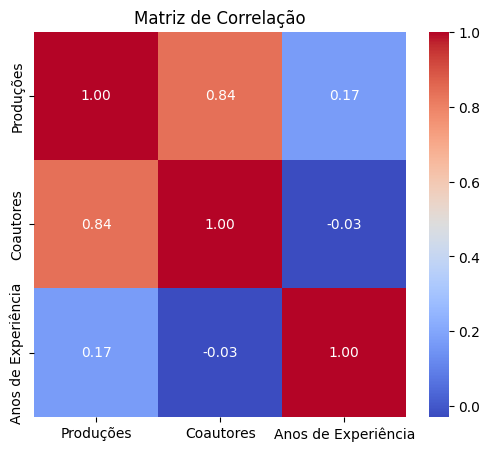

In [56]:
cols = [
    "quantidade_producoes_bibliograficas",
    "quantidade_coautores",
    "anos_experiencia",
]

colunas_legenda = {
    "quantidade_producoes_bibliograficas": "Produções",
    "quantidade_coautores": "Coautores",
    "anos_experiencia": "Anos de Experiência",
}

df_corr = df[cols].dropna().rename(columns=colunas_legenda)

# Calcula a matriz de correlação
corr_matrix = df_corr.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

In [57]:
prof_names = set(df["nome"].dropna())
pairs = coautores_df[coautores_df["coautor"].isin(prof_names)]
pairs = pairs[pairs["nome"] != pairs["coautor"]]
pc = pairs.groupby(["nome", "coautor"]).size().reset_index(name="count")

In [58]:
edge_agg = defaultdict(int)
for _, r in pc.iterrows():
    a, b, c = r["nome"], r["coautor"], int(r["count"])
    edge_agg[tuple(sorted((a, b)))] += c

prod_counts = (
    df.set_index("nome")["quantidade_producoes_bibliograficas"].fillna(0).to_dict()
)
vals = np.array(list(prod_counts.values()) or [0], dtype=float)
mn, mx = vals.min(), vals.max()
min_size, max_size = 24, 140  # maiores para destaque


def scale_size(v):
    if mx == mn:
        return (min_size + max_size) / 2
    # usar raiz para reduzir skew entre extremos
    v_s = np.sqrt(v)
    mn_s = np.sqrt(mn)
    mx_s = np.sqrt(mx)
    return float(min_size + (v_s - mn_s) / (mx_s - mn_s) * (max_size - min_size))


weights = np.array(list(edge_agg.values()) or [1], dtype=float)
wmin, wmax = weights.min(), weights.max()
min_w, max_w = 1.0, 10.0


def scale_w(w):
    if wmax == wmin:
        return (min_w + max_w) / 2
    return float(min_w + (w - wmin) / (wmax - wmin) * (max_w - min_w))


G = nx.Graph()
for n in sorted(prof_names):
    G.add_node(n, producoes=int(prod_counts.get(n, 0)))
for (a, b), w in edge_agg.items():
    G.add_edge(a, b, weight=int(w))

pos = nx.spring_layout(G, seed=1)

edge_traces = []
for u, v, data in G.edges(data=True):
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    w = data.get("weight", 1)
    edge_traces.append(
        go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            mode="lines",
            line=dict(width=scale_w(w), color="rgba(100,100,100,0.5)"),
            hoverinfo="text",
            text=f"{u} — {v}<br>Coautorias: {w}",
            showlegend=False,
        )
    )

node_x = [pos[n][0] for n in G.nodes()]
node_y = [pos[n][1] for n in G.nodes()]
node_sizes = [scale_size(G.nodes[n]["producoes"]) for n in G.nodes()]
node_text = [f"{n}<br>Produções: {G.nodes[n]['producoes']}" for n in G.nodes()]

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers+text",
    text=list(G.nodes()),
    textposition="top center",
    hoverinfo="text",
    hovertext=node_text,
    marker=dict(
        size=node_sizes,
        color=[prod_counts.get(n, 0) for n in G.nodes()],
        colorscale="Greens",
        colorbar=dict(title="Produções"),
        line=dict(width=2, color="rgba(30,30,30,0.85)"),
        opacity=0.95,
        symbol="circle",
    ),
    textfont=dict(size=11),
)

fig = go.Figure(
    data=edge_traces + [node_trace],
    layout=go.Layout(
        title="Rede de coautoria — CI",
        showlegend=False,
        hovermode="closest",
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            scaleanchor="y",
            scaleratio=1,
        ),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        dragmode="pan",
    ),
)

fig.update_layout(width=2000, height=1000)
fig.show(config={"scrollZoom": True})


### Rede de coautoria com logos de laboratório nos nós 
Nesta visualização, os professores do laboratório LASER terão o logo do laboratório sobreposto ao seu nó. Os demais laboratórios permanecem com marcador padrão. Para adicionar logos de outros laboratórios, basta incluir o caminho da imagem e atualizar o dicionário `lab_logos`.

In [ ]:
# tentativa 1 de colocr as logos dos lab nos professores, oq rolou aqui, basicamnete tem uma função que "corta" as imagemns, pra ficarem redondandas

import csv

import networkx as nx
import plotly.graph_objects as go
from PIL import Image, ImageDraw


def crop_circle(path):
    img = Image.open(path).convert("RGBA")
    size = min(img.size)
    mask = Image.new("L", (size, size), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0, 0, size, size), fill=255)
    output = Image.new("RGBA", (size, size), (0, 0, 0, 0))
    output.paste(img, ((size - img.size[0]) // 2, (size - img.size[1]) // 2))
    output.putalpha(mask)
    return output


def image_to_base64_circular(path):
    img = crop_circle(path)
    buffer = io.BytesIO()
    img.save(buffer, format="PNG")  # sempre salvar como PNG p/ transparência
    return base64.b64encode(buffer.getvalue()).decode()


# Lê o arquivo de laboratórios
prof_lab_map = {}
with open("../data/prof_labs.csv", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        prof_lab_map[row["Nome dos Professores"]] = row["Laboratório"]

# Dicionário de logos: laboratório -> caminho da imagem
lab_logos = {
    "LASER": "../labs_logos/laser_logo.png",
    "ARIA": "../labs_logos/aria_logo.jpg",
    "TRIL": "../labs_logos/tril_logo.png",  # ajuste o caminho conforme necessário
    # Adicione outros laboratórios se quiser
}


# Função para converter imagem para base64
def image_to_base64(path):
    with open(path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode()


# Recria o grafo e layout
G = nx.Graph()
for n in sorted(prof_names):
    G.add_node(n, producoes=int(prod_counts.get(n, 0)))
for (a, b), w in edge_agg.items():
    G.add_edge(a, b, weight=int(w))
pos = nx.spring_layout(G, seed=1)

# Arestas
edge_traces = []
for u, v, data in G.edges(data=True):
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    w = data.get("weight", 1)
    edge_traces.append(
        go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            mode="lines",
            line=dict(width=1 + w * 0.3, color="rgba(100,100,100,0.5)"),
            hoverinfo="text",
            text=f"{u} — {v}<br>Coautorias: {w}",
            showlegend=False,
        )
    )

# Nós que NÃO têm logo (cinza)
node_x = []
node_y = []
node_text = []
node_names = []
for n in G.nodes():
    lab = prof_lab_map.get(n, "")
    if lab not in lab_logos:
        node_x.append(pos[n][0])
        node_y.append(pos[n][1])
        node_text.append(f"{n}<br>Lab: {lab}")
        node_names.append(n)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers+text",
    text=node_names,
    textposition="top center",
    hoverinfo="text",
    hovertext=node_text,
    marker=dict(
        size=60,
        color="lightgray",
        line=dict(width=2, color="rgba(30,30,30,0.85)"),
        opacity=0.95,
        symbol="circle",
    ),
    textfont=dict(size=11),
)

fig = go.Figure(
    data=edge_traces + [node_trace],
    layout=go.Layout(
        title="Rede de coautoria — CI (com logos)",
        showlegend=False,
        hovermode="closest",
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            scaleanchor="y",
            scaleratio=1,
        ),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        dragmode="pan",
    ),
)

# Sobrepõe imagens dos laboratórios no lugar das bolinhas
for n in G.nodes():
    lab = prof_lab_map.get(n, "")
    if lab in lab_logos:
        img_path = lab_logos[lab]
        img_b64 = image_to_base64_circular(img_path)
    node_size = 60  # mesmo valor que você usou no marker.size
    scale = 0.003  # ajuste esse fator até o logo encaixar certinho
    logo_size = node_size * scale

    fig.add_layout_image(
        dict(
            source="data:image/png;base64," + img_b64,
            xref="x",
            yref="y",
            x=pos[n][0],
            y=pos[n][1],
            sizex=logo_size,
            sizey=logo_size,
            xanchor="center",
            yanchor="middle",
            layer="above",
        )
    )

fig.update_layout(width=2000, height=1000)
fig.show(config={"scrollZoom": True})

In [ ]:
# tentativa 1 de colocr as logos dos lab nos professores, oq rolou aqui, basicamnete tem uma função que "corta" as imagemns, pra ficarem redondandas

import csv

import networkx as nx
import plotly.graph_objects as go


def crop_circle(path):
    img = Image.open(path).convert("RGBA")
    size = min(img.size)
    mask = Image.new("L", (size, size), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0, 0, size, size), fill=255)
    output = Image.new("RGBA", (size, size), (0, 0, 0, 0))
    output.paste(img, ((size - img.size[0]) // 2, (size - img.size[1]) // 2))
    output.putalpha(mask)
    return output


def image_to_base64_circular(path):
    img = crop_circle(path)
    buffer = io.BytesIO()
    img.save(buffer, format="PNG")  # sempre salvar como PNG p/ transparência
    return base64.b64encode(buffer.getvalue()).decode()


# Lê o arquivo de laboratórios
prof_lab_map = {}
with open("../data/prof_labs.csv", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        prof_lab_map[row["Nome dos Professores"]] = row["Laboratório"]

# Dicionário de logos: laboratório -> caminho da imagem
lab_logos = {
    "LASER": "../labs_logos/laser_logo.png",
    "ARIA": "../labs_logos/aria_logo.jpg",
    "TRIL": "../labs_logos/tril_logo.png",  # ajuste o caminho conforme necessário
    # Adicione outros laboratórios se quiser
}


# Função para converter imagem para base64
def image_to_base64(path):
    with open(path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode()


# Recria o grafo e layout
G = nx.Graph()
for n in sorted(prof_names):
    G.add_node(n, producoes=int(prod_counts.get(n, 0)))
for (a, b), w in edge_agg.items():
    G.add_edge(a, b, weight=int(w))
pos = nx.spring_layout(G, seed=1)

# Arestas
edge_traces = []
for u, v, data in G.edges(data=True):
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    w = data.get("weight", 1)
    edge_traces.append(
        go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            mode="lines",
            line=dict(width=1 + w * 0.3, color="rgba(100,100,100,0.5)"),
            hoverinfo="text",
            text=f"{u} — {v}<br>Coautorias: {w}",
            showlegend=False,
        )
    )

# Nós que NÃO têm logo (cinza)
node_x = []
node_y = []
node_text = []
node_names = []
for n in G.nodes():
    lab = prof_lab_map.get(n, "")
    if lab not in lab_logos:
        node_x.append(pos[n][0])
        node_y.append(pos[n][1])
        node_text.append(f"{n}<br>Lab: {lab}")
        node_names.append(n)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers+text",
    text=node_names,
    textposition="top center",
    hoverinfo="text",
    hovertext=node_text,
    marker=dict(
        size=60,
        color="lightgray",
        line=dict(width=2, color="rgba(30,30,30,0.85)"),
        opacity=0.95,
        symbol="circle",
    ),
    textfont=dict(size=11),
)

fig = go.Figure(
    data=edge_traces + [node_trace],
    layout=go.Layout(
        title="Rede de coautoria — CI (com logos)",
        showlegend=False,
        hovermode="closest",
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            scaleanchor="y",
            scaleratio=1,
        ),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        dragmode="pan",
    ),
)

# Sobrepõe imagens dos laboratórios no lugar das bolinhas
for n in G.nodes():
    lab = prof_lab_map.get(n, "")
    if lab in lab_logos:
        img_path = lab_logos[lab]
        img_b64 = image_to_base64_circular(img_path)
        fig.add_layout_image(
            dict(
                source="data:image/png;base64," + img_b64,
                xref="x",
                yref="y",
                x=pos[n][0],
                y=pos[n][1],
                sizex=0.15,
                sizey=0.15,  # ajuste do tamanho da logo
                xanchor="center",
                yanchor="middle",
                layer="above",
            )
        )

fig.update_layout(width=2000, height=1000)
fig.show(config={"scrollZoom": True})